In [8]:
%%capture
import pathlib
import xarray as xr
import glob
import pandas as pd
import netCDF4
import matplotlib.pyplot as plt
import numpy as np
import hvplot.pandas
import hvplot.dask  # noqa
import dask
from scipy import stats
from datetime import datetime
import re
import os

In [2]:
data_dir = pathlib.Path('/home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample')

In [3]:
# Function to extract start date from filename
def extract_start_date(file_path):
    # Extract the date string using regex
    match = re.search(r'_(\d{8}T\d{6})\.\d+-', file_path.name)
    if match:
        date_str = match.group(1)
        # Convert to datetime object
        return datetime.strptime(date_str, '%Y%m%dT%H%M%S')
    return datetime.min  # Fallback date if pattern doesn't match

In [4]:
def extract_file_info(file_paths):
    # Create empty lists for each column
    deployments = []
    instrument_ids = []
    start_dates = []
    end_dates = []
    file_paths_list = []
    
    # Extract information from each path
    for path in file_paths:
        # Convert to string if it's a Path object
        file_name = path.name if hasattr(path, 'name') else str(path).split('/')[-1]
        file_paths_list.append(str(path))
        
        # Split by underscore
        parts = file_name.split('_')
        
        # Extract deployment (format: "deployment0002")
        deployment = parts[0].replace('deployment', '')
        deployments.append(deployment)
        
        # Extract instrument ID (should be at index 1)
        instrument_id = parts[1]
        instrument_ids.append(instrument_id)
        
        # Extract dates (format: "20240204T084530.998350-20240205T084720.951573.nc")
        date_part = parts[-1]  # Last element contains the dates
        date_part = date_part.replace('.nc', '')  # Remove file extension
        date_ranges = date_part.split('-')
        
        # Parse start and end dates
        start_str = date_ranges[0]
        end_str = date_ranges[1]
        
        # Convert to datetime objects
        start_date = datetime.strptime(start_str.split('.')[0], '%Y%m%dT%H%M%S')
        end_date = datetime.strptime(end_str.split('.')[0], '%Y%m%dT%H%M%S')
        
        start_dates.append(start_date)
        end_dates.append(end_date)
    
    # Create the DataFrame
    df = pd.DataFrame({
        'deployment': deployments,
        'instrument_id': instrument_ids,
        'start_date': start_dates,
        'end_date': end_dates,
        'file_path': file_paths_list
    })
    
    # Calculate duration
    df['duration_days'] = (df['end_date'] - df['start_date']).dt.total_seconds() / (3600 * 24)
    
    # Sort by start date
    df = df.sort_values('start_date').reset_index(drop=True)
    
    return df



In [5]:
# Get list of NetCDF files
file_list = list(data_dir.glob("*.nc"))

# Sort files by start date
sorted_files = sorted(file_list, key=extract_start_date)

# Take a subset of chronologically ordered files
netcdf_files_sub = sorted_files[0:3] 

In [6]:
file_info_df = extract_file_info(file_list)

file_info_df.head()

,deployment,instrument_id,start_date,end_date,file_path,duration_days
0,0001,RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf,2014-09-29 19:03:12,2016-05-30 23:59:51,/home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSF...,609.206007
1,0001,RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf,2016-05-31 00:00:03,2017-07-24 23:59:56,/home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSF...,419.999919
2,0001,RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf,2017-07-25 00:00:01,2017-08-13 23:22:26,/home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSF...,19.973900
3,0002,RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf,2017-08-15 00:31:30,2019-01-15 23:59:55,/home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSF...,518.978067
4,0002,RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf,2019-01-16 00:00:05,2020-06-26 23:59:57,/home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSF...,527.999907


In [9]:
# Get file sizes without opening any files
file_sizes_mb = []

for file in file_list:
    try:
        # Get file size in MB
        file_size_mb = os.path.getsize(file) / (1024 * 1024)
        file_sizes_mb.append(file_size_mb)
    except Exception as e:
        print(f"Error getting size for {file}: {e}")
        file_sizes_mb.append(None)

# Add to your dataframe
file_info_df['file_size_mb'] = file_sizes_mb

In [14]:
file_info_df.sort_values("file_size_mb", ascending=False).head()

,deployment,instrument_id,start_date,end_date,file_path,duration_days,file_size_mb
602,0002,RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf,2024-06-11 08:33:26,2024-06-12 08:34:16,/home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSF...,1.000579,418.925694
120,0002,RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf,2023-01-17 12:40:04,2023-01-18 12:36:54,/home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSF...,0.997801,409.929934
561,0002,RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf,2024-04-29 08:41:41,2024-04-30 08:32:50,/home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSF...,0.993854,409.657904
571,0002,RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf,2024-05-09 08:29:01,2024-05-10 08:24:41,/home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSF...,0.996991,408.341732
608,0002,RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf,2024-06-17 08:37:16,2024-06-18 08:37:26,/home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSF...,1.000116,404.728557


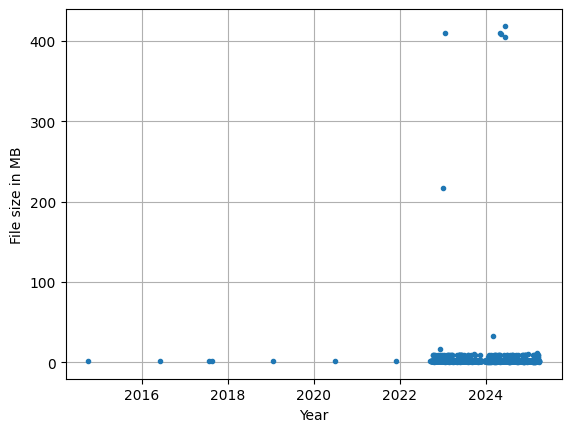

In [20]:
plt.plot(file_info_df["start_date"], file_info_df["file_size_mb"],'.')
plt.xlabel('Year')
plt.ylabel('File size in MB')
plt.grid(True)

In [23]:
netcdf_files_sub = file_list[800:804]
netcdf_files_sub

[PosixPath('/home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0002_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20221025T082104.395079-20221026T074344.343562.nc'),
 PosixPath('/home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0002_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20230212T110502.940735-20230213T110032.894409.nc'),
 PosixPath('/home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0002_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20240104T084658.951508-20240105T083348.897119.nc'),
 PosixPath('/home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0002_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20230223T104932.409286-20230224T104302.359534.nc')]

In [32]:
ds = xr.open_mfdataset(
    netcdf_files_sub,
    combine='nested',       # Use nested to concatenate along an existing dimension
    concat_dim='obs',       # Concatenate along the 'obs' dimension
    compat='override',      # Override any metadata conflicts
    coords='minimal',       # Use minimal coords
    join='outer'            # Use outer join to include all variables from all files
)

# Sort the resulting dataset by time
ds = ds.sortby('time')

In [33]:
print(ds)

<xarray.Dataset> Size: 10MB
Dimensions:                    (obs: 34195)
Coordinates:
  * obs                        (obs) int32 137kB 0 1 2 3 ... 8558 8559 8560 8561
    time                       (obs) datetime64[ns] 274kB dask.array<chunksize=(8548,), meta=np.ndarray>
Data variables: (12/83)
    temperature14_qc_executed  (obs) uint8 34kB dask.array<chunksize=(8548,), meta=np.ndarray>
    battery_voltage            (obs) float32 137kB dask.array<chunksize=(8548,), meta=np.ndarray>
    temperature06_qc_executed  (obs) uint8 34kB dask.array<chunksize=(8548,), meta=np.ndarray>
    temperature23              (obs) float32 137kB dask.array<chunksize=(8548,), meta=np.ndarray>
    temperature10_qc_executed  (obs) uint8 34kB dask.array<chunksize=(8548,), meta=np.ndarray>
    temperature24_qc_executed  (obs) uint8 34kB dask.array<chunksize=(8548,), meta=np.ndarray>
    ...                         ...
    temperature19_qc_executed  (obs) uint8 34kB dask.array<chunksize=(8548,), meta=np.ndarray